# NLP with Recurrent Neural Network

Author: Rafael Godoy

LinkedIn: https://www.linkedin.com/in/Rafael-Godoy-ML-Eng

Github: https://github.com/RafaelSilvaGodoy


This notebook will show how to use a **Recurrent Neural Network** for **Natural Language Processing** the IMDB movies review.



The dataset was provided by [kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

# String format functions

In [3]:
import re
import unicodedata

def no_alphas( phrase_tokenized ):
    return [word for word in phrase_tokenized if (word.isalpha())]
    
def remove_stops( phrase_tokenized, stopwords):
    w_token_1_wo_stopwords = [word for word in phrase_tokenized if word not in stopwords]
    return w_token_1_wo_stopwords

def reconstruct_phrase( phrase_tokenized ):
    return ' '.join( phrase_tokenized )

In [4]:
df_imdb = pd.read_csv('/content/IMDB Dataset.csv')
print(df_imdb.shape)
df_imdb.sample(4)

(50000, 2)


,review,sentiment
43786,How could this get a 6.0 rating? Are we as hor...,negative
47002,The idea ia a very short film with a lot of in...,positive
6269,Roger Corman is undeniably one of the most ver...,negative
46584,"Season after season, the players or characters...",positive


# NLTK downloads & Data preparation

In [6]:
%%capture
import nltk
nltk.download('popular')

In [7]:
from nltk.tokenize import word_tokenize

df_imdb['rev_token'] = df_imdb['review'].str.lower().apply(word_tokenize)

In [8]:
from nltk.corpus import stopwords
from string import punctuation

stw = stopwords.words('english')

extra_remove_words = ['br',"'s","''","``"]
remove_list = set(stw + list(punctuation) + extra_remove_words)

df_imdb['rev_token_stw'] = df_imdb['rev_token'].apply(remove_stops, stopwords=remove_list)

df_imdb['rev_token_stw_alpha'] = df_imdb['rev_token_stw'].apply(no_alphas)

# General Reviews Word Cloud

The frequency of the word on the reviews is reflected on its size.

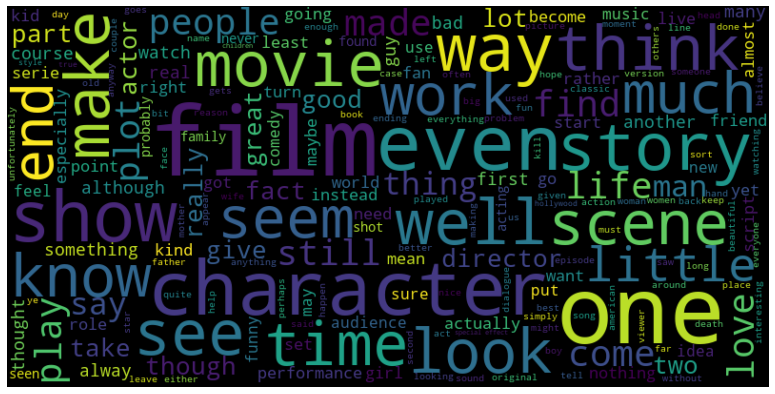

In [9]:
df_imdb['rec'] = df_imdb['rev_token_stw_alpha'].apply(reconstruct_phrase)


text_column = df_imdb['rec'].copy()
reviews = " ".join(review for review in text_column)

wordcloud = WordCloud(max_font_size=100, max_words=200, width=800, height=400).generate(reviews)
plt.figure(figsize=[15,7])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Positive Reviews Word Cloud

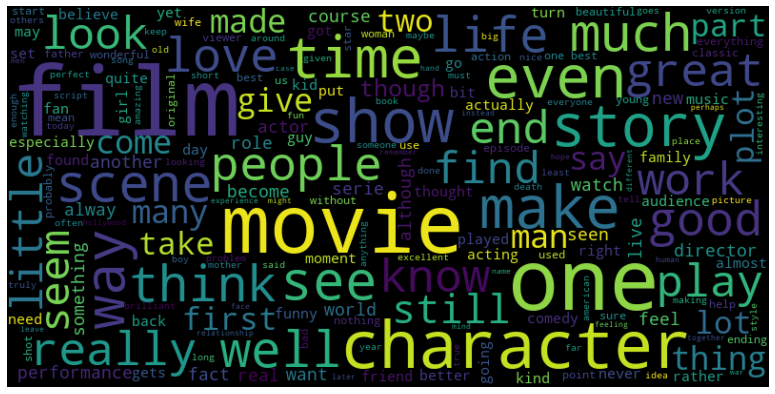

In [20]:
positive_flag = df_imdb['sentiment'] == 'positive'
negative_flag = df_imdb['sentiment'] == 'negative'

text_column = df_imdb[positive_flag]['rec'].copy()
reviews = " ".join(review for review in text_column)

wordcloud = WordCloud(max_font_size=100, max_words=200, width=800, height=400).generate(reviews)
plt.figure(figsize=[15,7])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Negative Reviews Word Cloud

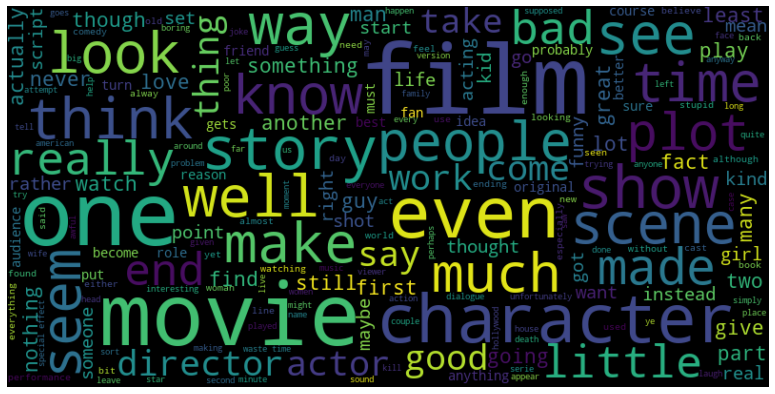

In [21]:
text_column = df_imdb[negative_flag]['rec'].copy()
reviews = " ".join(review for review in text_column)

wordcloud = WordCloud(max_font_size=100, max_words=200, width=800, height=400).generate(reviews)
plt.figure(figsize=[15,7])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Text Vectorization

Text Vectorization is the process of converting text into numerical representation.

In [10]:
from tensorflow.keras.layers import TextVectorization

vocab_size_max = 20_000
sequence_length = 950

proc_column = df_imdb['rec']

vectorizer = TextVectorization(
                                  max_tokens = vocab_size_max,
                                 output_mode = 'int',
                                 output_sequence_length = sequence_length
)

vectorizer.adapt(proc_column.values)
vectorized_text = vectorizer(proc_column.values)

# Model Development

In [11]:
from sklearn.model_selection import train_test_split

df_vetorized = pd.DataFrame(vectorized_text.numpy())
y = np.array(df_imdb['sentiment'].apply(lambda x: 1 if x == 'positive' else 0))

X_train, X_test, y_train, y_test = train_test_split(df_vetorized,y,test_size=0.3)

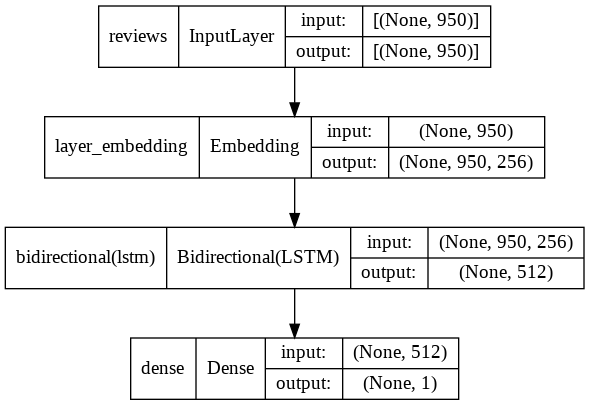

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import layers
from tensorflow import keras

call_es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
call_mc = ModelCheckpoint(filepath='/content/model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)

x_dim = sequence_length
embedding_size = 256 # dimention to represent the word

text_input = keras.Input(shape=(x_dim,), name='reviews')
text_feature = layers.Embedding(input_dim=vocab_size_max, output_dim=embedding_size, input_length=sequence_length, name='layer_embedding', mask_zero=True)(text_input)
x_lstm = Bidirectional(LSTM(units=256, dropout=0, ))(text_feature)
text_out = layers.Dense(1, activation='sigmoid')(x_lstm)

model2 = keras.Model(
                    inputs=[text_input],
                    outputs=[text_out])

keras.utils.plot_model(model2,"model_in_out.png", show_shapes=True)

In [14]:
from tensorflow.keras import optimizers

adam = optimizers.Adam(learning_rate = 0.001)
model2.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = adam)

model2.fit(X_train,y_train, batch_size=64, epochs=15, callbacks=[call_es,call_mc], validation_data=(X_test,y_test))

Epoch 1/15
547/547 [==============================] - 177s 305ms/step - loss: 0.1111 - accuracy: 0.9608 - val_loss: 0.3683 - val_accuracy: 0.8793
Epoch 2/15
547/547 [==============================] - 164s 301ms/step - loss: 0.0604 - accuracy: 0.9799 - val_loss: 0.4368 - val_accuracy: 0.8777
Epoch 3/15
547/547 [==============================] - 165s 301ms/step - loss: 0.0269 - accuracy: 0.9916 - val_loss: 0.5580 - val_accuracy: 0.8688
Epoch 4/15
547/547 [==============================] - 165s 302ms/step - loss: 0.0251 - accuracy: 0.9921 - val_loss: 0.5585 - val_accuracy: 0.8701
Epoch 5/15
547/547 [==============================] - 166s 303ms/step - loss: 0.0179 - accuracy: 0.9940 - val_loss: 0.6176 - val_accuracy: 0.8703
Epoch 6/15
547/547 [==============================] - 165s 302ms/step - loss: 0.0082 - accuracy: 0.9977 - val_loss: 0.7082 - val_accuracy: 0.8680
Epoch 7/15
547/547 [==============================] - 167s 305ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.9040 -

# Model Validation

The model's output is a probability between 0 and 1, where the closer to 1, the better the revision, while the closer to 0, the worse it is.

## Good review (0.98)

In [16]:
input_exemple = vectorizer( "I think that the movie is great" )

model2.predict(input_exemple.numpy().reshape(1, 950) )

array([[0.98621875]], dtype=float32)

## Mixed feelings review (0.64)

In [15]:
input_exemple = vectorizer( "I think that the movie is ok" )

model2.predict(input_exemple.numpy().reshape(1, 950) )

array([[0.6462521]], dtype=float32)

## Bad review (0.00)

In [17]:
input_exemple = vectorizer( "I think that the movie is bad" )

model2.predict(input_exemple.numpy().reshape(1, 950) )

array([[0.00140258]], dtype=float32)

# Conclusion

The network was able to learn if a phrase is good or bad due to the labeled data from the data set.

Once it knows the represented feeling, the NN is able to create a latent space to represent the words in vectors and through its values, determine the phrase sentiment.

Notice that the NN was trained with reviews data therefore if a phrase with words from other contexts were used, it is probable that the results will not correspond to the actual sentiments.